In [1]:
import os
import torch
import sys
sys.path.append("../")
import argparse
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import logging 

In [2]:
def dice_score(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    smooth: float = 1e-6,
    eps: float = 1e-7,
    reduction: str = "mean"
) -> torch.Tensor:
    """
    Compute Dice score for multi-class segmentation.
    
    Args:
        inputs: (N, C, H, W) tensor of logits/probabilities
        targets: (N, C, H, W) one-hot encoded targets OR (N, H, W) class indices
        smooth: Laplace smoothing factor
        eps: Numerical stability term
        reduction: "mean"|"none"|"sum"
    
    Returns:
        Dice score (scalar or per-class scores)
    """
    # Convert targets to one-hot if needed
    if targets.dim() == 3:
        targets = torch.eye(inputs.shape[1], device=targets.device)[targets].permute(0,3,1,2)
    
    # Normalize inputs if needed (assumes inputs are logits)
    if inputs.size(1) > 1:
        probs = torch.softmax(inputs, dim=1)
    else:
        probs = torch.sigmoid(inputs)
    
    # Compute intersection and union
    dims = (0, 2, 3)  # Batch and spatial dims
    intersection = torch.sum(probs * targets, dim=dims)
    cardinality = torch.sum(probs + targets, dim=dims)
    
    # Compute dice per class
    dice = (2. * intersection + smooth) / (cardinality + smooth + eps)
    
    if reduction == "mean":
        return dice.mean()
    elif reduction == "sum":
        return dice.sum()
    return dice  # per-class scores

Image shape: (1024, 1024, 3)
Image dtype: uint8


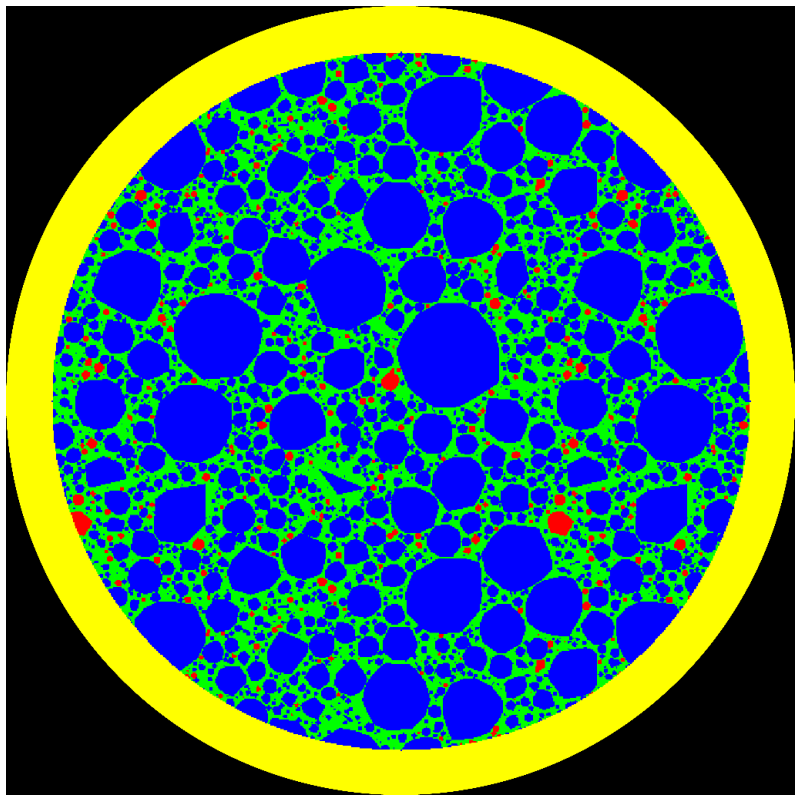

In [3]:
import numpy as np
import cv2 as cv
res = 1024
# img = cv.imread(f'/Users/zezzz/Downloads/samples/131900-2019-01-00-03-01/rescaled_image_0_{res}x{res}.png') 
# img = cv.imread(f'/Users/zezzz/Downloads/samples/149600-2019-01-00-03-01/rescaled_image_0_{res}x{res}.png') 

img_path = f'/Users/zezzz/Desktop/zez/samples/s8d/selected/mask_epoch_71_sample_2.png'
img = cv.imread(img_path)
img = cv.resize(img, (res, res))

# Check if image loaded properly
if img is None:
    print(f"Error: Could not load image from {img_path}")
else:
    # Convert from BGR to RGB (OpenCV loads as BGR, matplotlib displays as RGB)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Check image properties
    print(f"Image shape: {img.shape}")
    print(f"Image dtype: {img.dtype}")
    
    # Display image
    fig, ax = plt.subplots(figsize=(16, 16), dpi=64)
    plt.imshow(img_rgb)
    ax.axis("off")
    plt.show()
    plt.close()

In [4]:
from torchvision import transforms
mask = cv.imread(img_path)
if mask is None:
    raise ValueError(f"Could not load image from {img_path}")

# Convert from BGR to RGB
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = cv.resize(mask, (res, res))

# Convert RGB mask to class indices (assuming specific RGB values represent classes)
# You need to define how RGB values map to class indices
# This is just an example - adjust based on your actual color mapping
palette = np.array([
    [0, 0, 0],       # Class 0 - Black
    [255, 0, 0],     # Class 1 - Red
    [0, 255, 0],     # Class 2 - Green
    [0, 0, 255],     # Class 3 - Blue
    [255, 255, 0],   # Class 4 - Yellow
    [255, 0, 255]    # Class 5 - Magenta (if needed)
], dtype=np.uint8)

# Create class index mask
h, w = mask.shape[:2]
class_mask = torch.zeros((h, w), dtype=torch.long)

for class_idx, color in enumerate(palette):
    # Find all pixels matching this class color
    matches = (mask == color).all(axis=-1)
    class_mask[matches] = class_idx

# Convert to one-hot encoding
onehot_mask = F.one_hot(class_mask, num_classes=5)

# Permute dimensions to [C, H, W] format
onehot_mask = onehot_mask.permute(2, 0, 1).float()

In [5]:
print(onehot_mask.shape, mask.shape)

torch.Size([5, 1024, 1024]) (1024, 1024, 3)


In [6]:
from model.unet import Unet, LightweightUNet
from utils.focal_loss import DiceCELoss

model = Unet(n_class=5, in_channels=5, pretrained=False)
criterion = DiceCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/zezzz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zezzz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
onehot_mask.shape
onehot_mask = onehot_mask.unsqueeze(0)
# print(mask.dtype,output.dtype)

In [26]:
for i in range(100):
    print(onehot_mask.shape)
    output = model(onehot_mask)

    optimizer.zero_grad()
    loss = criterion(output, onehot_mask)
    print(loss)
    score = dice_score(output, onehot_mask)
    print(score)
    loss.backward()
    optimizer.step()

torch.Size([1, 5, 1024, 1024])
tensor(1.2314, grad_fn=<AddBackward0>)
tensor(0.4739, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2306, grad_fn=<AddBackward0>)
tensor(0.4741, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2299, grad_fn=<AddBackward0>)
tensor(0.4743, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2292, grad_fn=<AddBackward0>)
tensor(0.4745, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2284, grad_fn=<AddBackward0>)
tensor(0.4747, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2277, grad_fn=<AddBackward0>)
tensor(0.4748, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2270, grad_fn=<AddBackward0>)
tensor(0.4750, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2263, grad_fn=<AddBackward0>)
tensor(0.4752, grad_fn=<MeanBackward0>)
torch.Size([1, 5, 1024, 1024])
tensor(1.2255, grad_fn=<AddBackward0>)
tensor(0.4754, grad_fn=<MeanBackward0>)
torch.Size

In [23]:
pred_mask = output[0].argmax(axis=0)  # (H, W)
from PIL import Image
# Create color palette (5 classes + background)
palette = np.array([
    [0, 0, 0],       # Class 0 - Black
    [255, 0, 0],     # Class 1 - Red
    [0, 255, 0],     # Class 2 - Green
    [0, 0, 255],     # Class 3 - Blue
    [255, 255, 0],   # Class 4 - Yellow
    [255, 0, 255]    # Class 5 - Magenta (if needed)
], dtype=np.uint8)

# Apply color mapping
colored_mask = palette[pred_mask]
Image.fromarray(colored_mask).save("inf_s8d.png")

In [24]:
pred_mask = onehot_mask[0].argmax(axis=0)  # (H, W)
from PIL import Image
# Create color palette (5 classes + background)
palette = np.array([
    [0, 0, 0],       # Class 0 - Black
    [255, 0, 0],     # Class 1 - Red
    [0, 255, 0],     # Class 2 - Green
    [0, 0, 255],     # Class 3 - Blue
    [255, 255, 0],   # Class 4 - Yellow
    [255, 0, 255]    # Class 5 - Magenta (if needed)
], dtype=np.uint8)

# Apply color mapping
colored_mask = palette[pred_mask]
Image.fromarray(colored_mask).save("mask_s8d.png")